In [26]:
import nibabel as nib
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn import plotting

import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, iirfilter, freqs
from scipy.signal import freqz
from scipy import stats
from scipy.stats import pearsonr
from scipy import signal
import os
import subprocess
import time

In [53]:
labels = pd.read_csv("./inputs/labels_reduc.txt", sep=",", header=None)

In [27]:
def savefiles(mtx, title, filename, typ):
    
    if (typ == "png") or (typ == "pngcsv"):
        # save img
        plt.matshow(mtx)
        plt.title(title)
        plt.colorbar()
        plt.xticks(labels[0], labels[1], rotation='vertical', fontsize=7)
        plt.clim(0,1)
        plt.savefig(filename+".png")
        plt.close()

    if (typ == "csv") or (typ == "pngcsv"):
        # save csv
        np.savetxt(filename+".csv", mtx , delimiter=",")

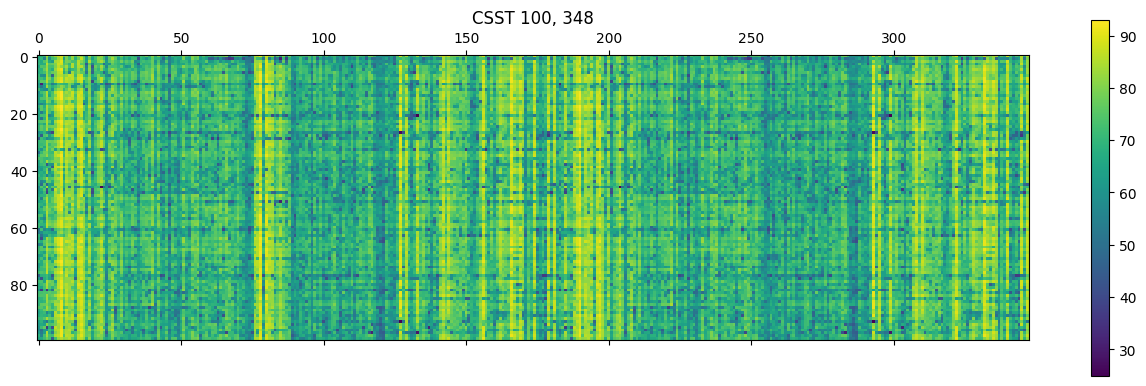

In [28]:
""" SECOND LEVEL ANALYSIS """

# Get the list of all files and directories
in_path_CN = "./outputs/connect_state/CN/"
in_path_AD = "./outputs/connect_state/AD/"
dir_list_CN = os.listdir(in_path_CN)
dir_list_AD = os.listdir(in_path_AD)

N_voxels = 100
N_states = len(dir_list_CN) + len(dir_list_AD)
CSST = np.zeros([N_voxels, N_states]) # 100, 182+166=348

# connectivity states
E = dict()

for state, value in enumerate(dir_list_CN + dir_list_AD):

    try:
        E[state] = pd.read_csv(in_path_CN+value, header=None) # 100, 100
    except:
        E[state] = pd.read_csv(in_path_AD+value, header=None) # 100, 100
        
    # connectivity strength of each state
    CSST[:,state] = E[state].sum(axis=1) # 100, 348

# visualise
plt.matshow(CSST)
plt.title("CSST "+str(N_voxels)+", "+str(N_states))
plt.colorbar()
plt.show()
savefiles(CSST, "CSST", "./outputs/connect_state/CSST", "pngcsv")

# new similarity matrix
CSST = pd.DataFrame(CSST)
Ccsst = CSST.corr(method ='pearson')
savefiles(Ccsst, "Ccsst", "./outputs/connect_state/Ccsst", "pngcsv")

In [94]:
# go to matlab

# the modular organization of this similarity matrix, Scsst(348 × 348), 
# is assessed.

script_path = "modul_Scsst.m"
# Start the MATLAB subprocess
matlab_process = subprocess.Popen(['matlab', '-nodisplay', '-nosplash', '-nodesktop', '-r', f"run('{script_path}')"])

time.sleep(35)

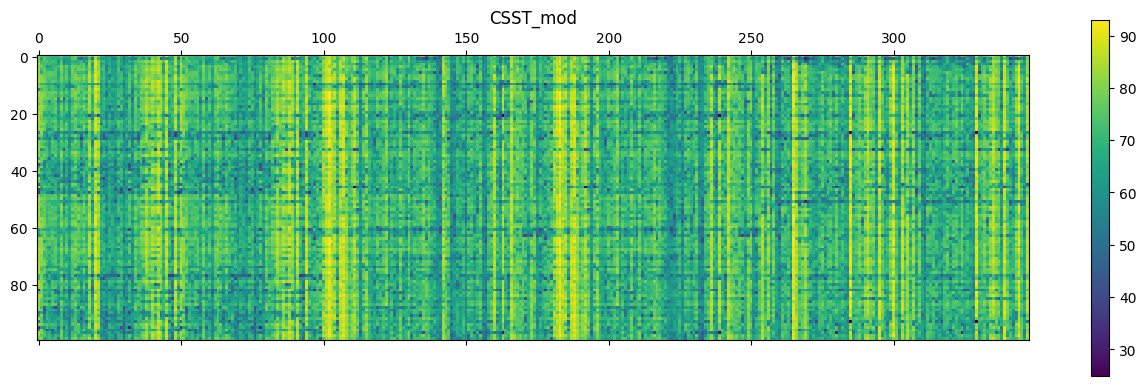

In [ ]:
# get modularity distribution
Ci = np.array(pd.read_csv("./outputs/modularity/Ci_csst.csv", header=None))

# organize it
max_Ci = int(max(Ci))
CSST_mod = []
CSST = np.array(CSST)
mod_inds = dict()
for m in (range(1,max_Ci+1)): # m = 3
    ind = [index for index, value in enumerate(Ci) if value == m]
    mod_inds[m] = ind
    for i in ind:
        # order
        CSST_mod.append(CSST[:,i])

CSST_mod = np.array(CSST_mod)
plt.matshow(CSST_mod.T)
plt.title("CSST_mod")
plt.colorbar()
plt.show()

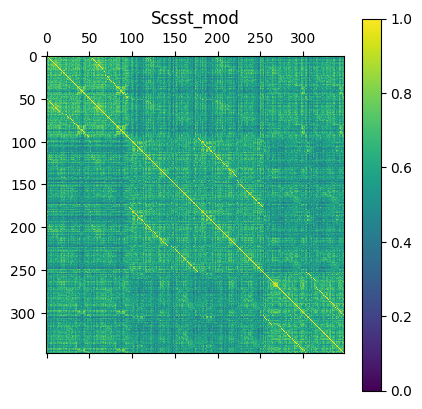

In [75]:
# get the correlation 

CSST_mod = pd.DataFrame(CSST_mod.T)
csst_mod = CSST_mod.corr(method ='pearson')
Scsst_mod = (csst_mod + 1)/ 2

plt.matshow(Scsst_mod)
plt.title("Scsst_mod")
plt.colorbar()
plt.clim(0,1)
plt.show()

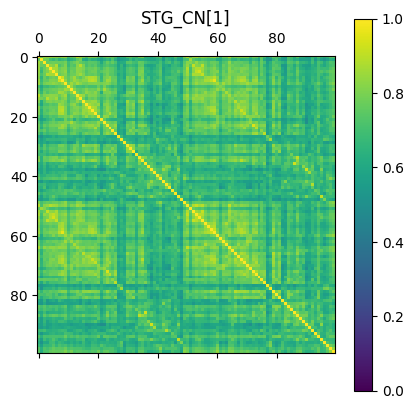

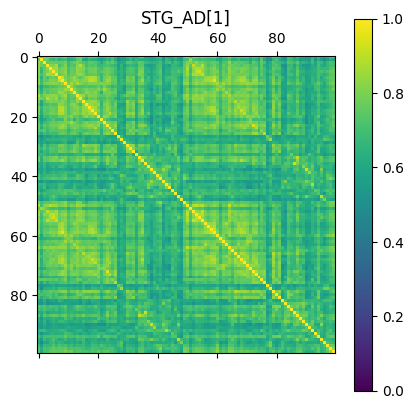

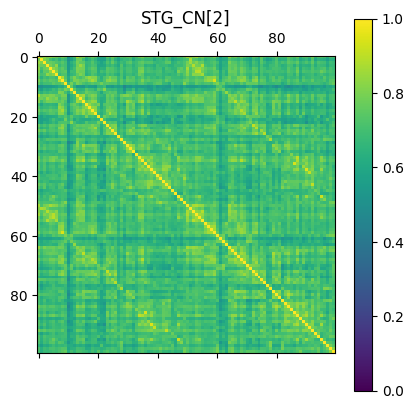

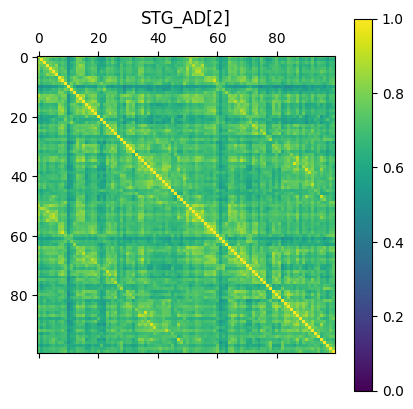

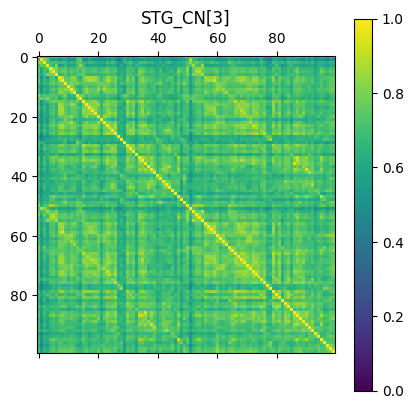

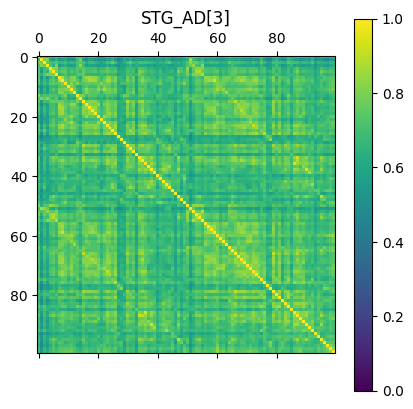

In [ ]:
# Finally, the similarity matrices of the first-level connectivity
# states belonging to the same module are averaged into one graph, STG(100 × 100), 
# which is the corresponding second-level connectivity state

STG_CN = dict()
STG_AD = dict()
for mod_no in (range(1,max_Ci+1)):
    states_sum_CN = np.zeros([100, 100])
    states_sum_AD = np.zeros([100, 100])
    count_mod_CN = 0
    count_mod_AD = 0
    for ind in mod_inds[mod_no]:
        if ind < 182:
            states_sum_CN = states_sum_CN + E[ind]
            count_mod_CN = count_mod_CN + 1
        else:
            states_sum_AD = states_sum_AD + E[ind]
            count_mod_AD = count_mod_AD + 1
            
    STG_CN[mod_no] = states_sum_CN/count_mod_CN
    STG_AD[mod_no] = states_sum_AD/count_mod_AD
    
    plt.matshow(STG_CN[mod_no])
    plt.title("STG_CN["+str(mod_no)+"]")
    plt.clim(0.3,1)
    plt.colorbar()
    plt.show()
    
    plt.matshow(STG_AD[mod_no])
    plt.title("STG_AD["+str(mod_no)+"]")
    plt.clim(0.3,1)
    plt.colorbar()
    plt.show()

# states related to 1st module might be associated with age? or duration of disease

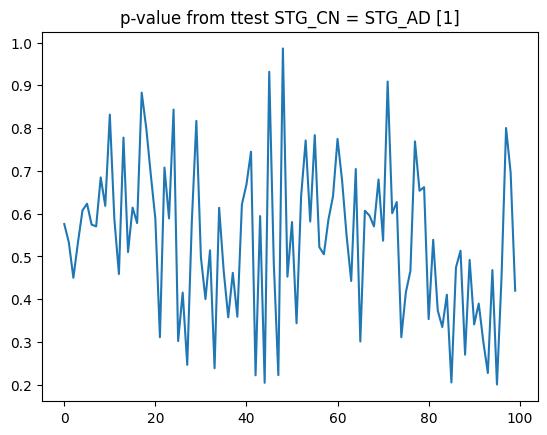

Empty DataFrame
Columns: []
Index: []


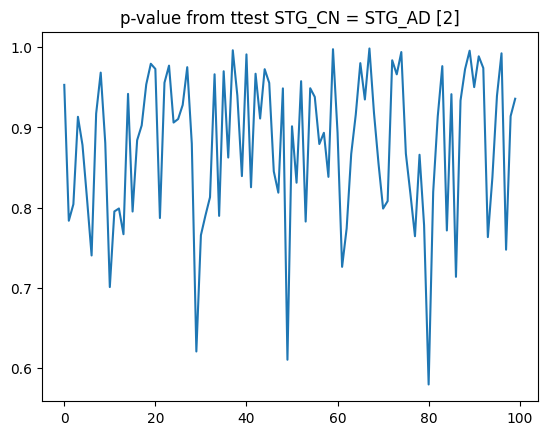

Empty DataFrame
Columns: []
Index: []


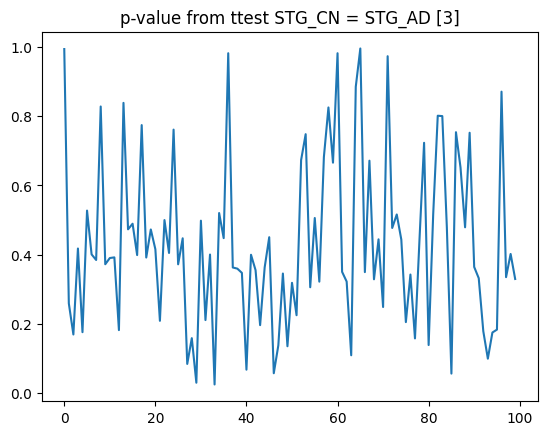

           0
29  0.030555
33  0.025493


In [ ]:
""" T-TEST -- STG_CN=STG_AD """
for mod_no in (range(1,max_Ci+1)):

    ttest = stats.ttest_ind(a=STG_CN[mod_no], b=STG_AD[mod_no], equal_var=True)

    plt.plot(ttest.pvalue)
    plt.title("p-value from ttest STG_CN = STG_AD ["+str(mod_no)+"]")
    plt.show()

    pval_accept = []
    pval_accept_ind = []
    for ind, pval in enumerate(ttest.pvalue):
        if pval < 0.05:
            pval_accept.append(pval)
            pval_accept_ind.append(ind)

    # print major areas of difference (p-value <0.05 so we can reject null hypothesis)     
    print(pd.DataFrame(pval_accept, pval_accept_ind))

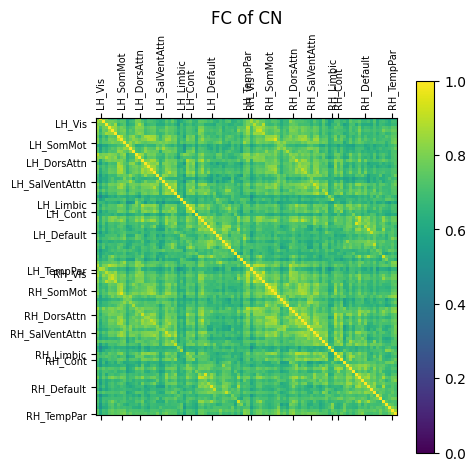

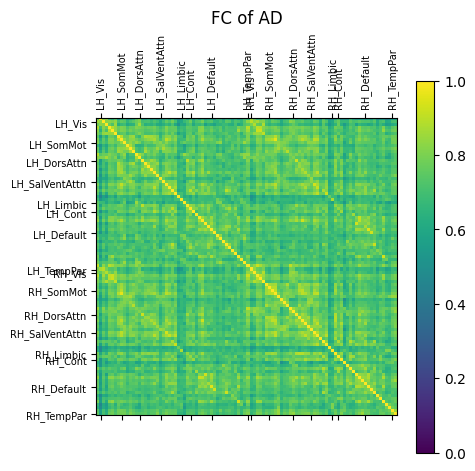

In [93]:
S_CN = pd.read_csv("./outputs/FC_CN.csv")
S_AD = pd.read_csv("./outputs/FC_AD.csv")

plt.matshow(S_CN)
plt.title("FC of CN")
plt.clim(0,1)
plt.colorbar()
plt.xticks(labels[0], labels[1], rotation='vertical', fontsize=7)
plt.yticks(labels[0], labels[1], rotation='horizontal', fontsize=7)
plt.show()

plt.matshow(S_AD)
plt.title("FC of AD")
plt.clim(0,1)
plt.colorbar()
plt.xticks(labels[0], labels[1], rotation='vertical', fontsize=7)
plt.yticks(labels[0], labels[1], rotation='horizontal', fontsize=7)
plt.show()

               0
4   2.205916e-02
10  2.607648e-05
11  3.008935e-04
12  5.463754e-03
16  3.602793e-02
20  6.355423e-04
21  9.166311e-03
22  7.318724e-03
26  4.386278e-02
29  1.157411e-02
33  5.695434e-07
37  3.522849e-02
38  5.638901e-04
46  2.500680e-07
48  1.738883e-04
50  3.908775e-02
53  3.654496e-02
63  1.629841e-04
73  4.201495e-03
76  1.146893e-02
81  3.105150e-02
82  1.107676e-02
88  4.091870e-07
89  4.419733e-04
90  5.861241e-04
91  9.000819e-04
95  4.725893e-03


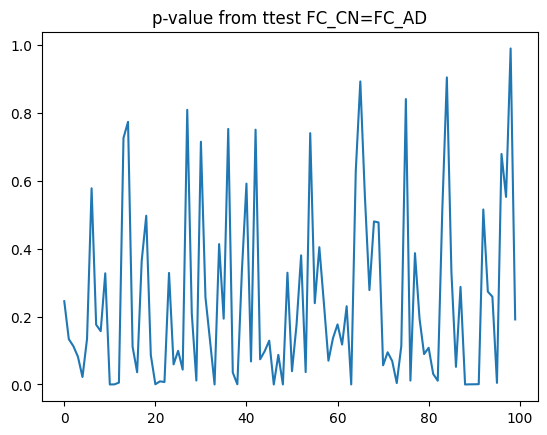

In [ ]:
#T-TEST -- FC_CN=FC_AD

ttest = stats.ttest_ind(a=S_CN, b=S_AD, equal_var=True)

plt.plot(ttest.pvalue)
plt.title("p-value from ttest FC_CN=FC_AD")

pval_accept = []
pval_accept_ind = []
for ind, pval in enumerate(ttest.pvalue):
    if pval < 0.05:
        pval_accept.append(pval)
        pval_accept_ind.append(ind)

# print major areas of difference (p-value <0.05 so we can reject FC_CN=FC_AD)     
print(pd.DataFrame(pval_accept, pval_accept_ind))


In [78]:
pd.DataFrame(pval_accept, pval_accept_ind).index

Int64Index([ 4, 10, 11, 12, 16, 20, 21, 22, 26, 29, 33, 37, 38, 46, 48, 50, 53,
            63, 73, 76, 81, 82, 88, 89, 90, 91, 95],
           dtype='int64')

In [79]:
"""add box plots - connectivity strength"""

data_strength_CN = []
data_strength_AD = []

CSST = np.array(CSST)
CSST_CN = (CSST[:,:181].sum(axis=0))/100
CSST_AD = (CSST[:,182:].sum(axis=0))/100


In [44]:
# go to matlab
script_path = "graph_measures.m"
# Start the MATLAB subprocess
matlab_process = subprocess.Popen(['matlab', '-nodisplay', '-nosplash', '-nodesktop', '-r', f"run('{script_path}')"])
time.sleep(200)

In [80]:
"""add box plots - clustering coef"""
C_CN = pd.read_csv("./outputs/clustering/first_level_states_C_CN.csv")
C_AD = pd.read_csv("./outputs/clustering/first_level_states_C_AD.csv")

"""add box plots - global efficiency"""
Eff_CN = pd.read_csv("./outputs/efficiency/first_level_states_Eff_CN.csv")
Eff_AD = pd.read_csv("./outputs/efficiency/first_level_states_Eff_AD.csv")

(0.52, 0.95)

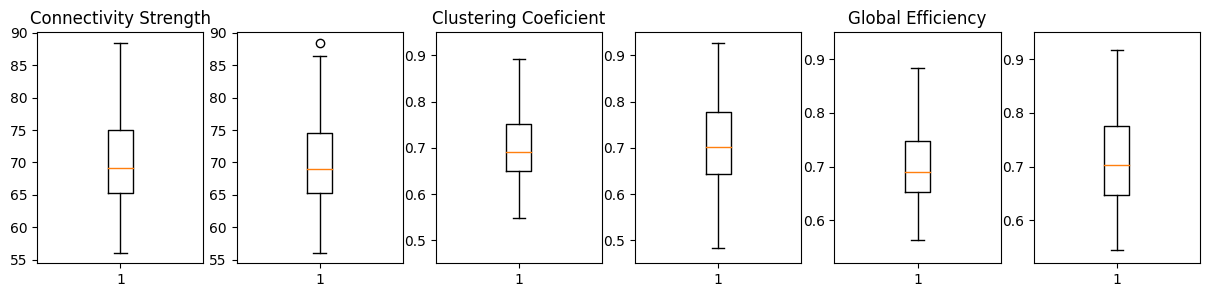

In [91]:
# visualizing

fig, axs = plt.subplots(1, 6, figsize=(15, 3))

# connection strength
axs[0].boxplot(CSST_CN)
axs[0].set_title("Connectivity Strength")
axs[1].boxplot(CSST_AD)
#axs[0,0].set_ylim(0.26, 0.38)
#axs[0,1].set_ylim(0.26, 0.38)

# clustering coef
axs[2].boxplot(C_CN)
axs[2].set_title("Clustering Coeficient")
axs[3].boxplot(C_AD)
axs[2].set_ylim(0.45, 0.95)
axs[3].set_ylim(0.45, 0.95)

# global efficiency
axs[4].boxplot(Eff_CN)
axs[4].set_title("Global Efficiency")
axs[5].boxplot(Eff_AD)
axs[4].set_ylim(0.52, 0.95)
axs[5].set_ylim(0.52, 0.95)

In [40]:
""" do same analysis on modules from 2nd level analysis """

mod_strength_CN = dict()
mod_strength_AD = dict()
for mod_no in (range(1,max_Ci+1)):
    tmp_CN = []
    tmp_AD = []
    for ind in mod_inds[mod_no]:
        if ind < 182:
            # state strength over all voxels
            state_strength_CN = (E[ind].sum(axis=1))/100
            tmp_CN.append((state_strength_CN.sum())/100)
        else:
            state_strength_AD = (E[ind].sum(axis=1))/100
            tmp_AD.append((state_strength_AD.sum())/100)

    mod_strength_CN[mod_no] = tmp_CN
    mod_strength_AD[mod_no] = tmp_AD

"""add box plots - clustering coef"""
# go to matlab

#C_CN = pd.read_csv("./outputs/clustering/first_level_states_C_CN.csv")
#C_AD = pd.read_csv("./outputs/clustering/first_level_states_C_AD.csv")

"""add box plots - global efficiency"""
#Eff_CN = pd.read_csv("./outputs/efficiency/first_level_states_Eff_CN.csv")
#Eff_AD = pd.read_csv("./outputs/efficiency/first_level_states_Eff_AD.csv")


'add box plots - global efficiency'

Text(0.5, 1.0, '2nd Connectivity Strength AD')

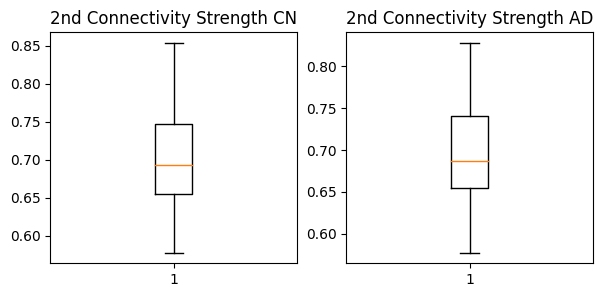

In [92]:
# visualizing 2ND LEVEL

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# connection strength
axs[0].boxplot(mod_strength_CN[1])
axs[0].set_title("2nd Connectivity Strength CN")
axs[1].boxplot(mod_strength_AD[1])
axs[1].set_title("2nd Connectivity Strength AD")
#axs[0,0].set_ylim(0.26, 0.38)
#axs[0,1].set_ylim(0.26, 0.38)

